In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow.keras as keras
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn import metrics

In [0]:
!wget -q https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [0]:
!unzip -q newdata-20200508T052237Z-001.zip

In [0]:
IMG_SIZE = 224
train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255.
)

validation_datagen = ImageDataGenerator(
    rescale=1./255.
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

training_set = train_datagen.flow_from_directory('/content/newdata/TRAIN_CROP',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = 32,
                                                 shuffle=True,
                                                 color_mode='rgb',
                                                 class_mode = 'binary')

validation_set = validation_datagen.flow_from_directory('/content/newdata/VAL_CROP',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/newdata/TEST_CROP',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode = 'binary')

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [0]:
IMAGE_SIZE = (IMG_SIZE, IMG_SIZE, 3)

weights = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE, weights=weights, include_top=False)

In [0]:
vgg.trainable = False   

# our layers - you can add more if you want
inputs = keras.Input(shape=IMAGE_SIZE)
x = vgg(inputs, training=False)
x = GlobalAveragePooling2D() (x)
x = Dropout(0.8) (x)
prediction = Dense(1, activation='sigmoid') (x)

# create a model object
model = Model(inputs=inputs, outputs=prediction)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(0.1, 10, 0.96, staircase=True)),
              metrics=["accuracy"])

Fine tune

In [0]:
vgg.trainable = True
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(1e-5, 8, 0.96, staircase=False)),
              metrics=["accuracy"])

Train

In [0]:
EPOCHS = 1000
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

VGG16_history = model.fit(training_set, validation_data=validation_set, epochs=EPOCHS, verbose=2, steps_per_epoch=8, validation_steps=1, callbacks=[earlystop])

In [0]:
model.evaluate(test_set, steps=1)

1/1 [==============================] - 0s 1ms/step - loss: 0.3285 - accuracy: 0.9000


[0.3284902274608612, 0.8999999761581421]

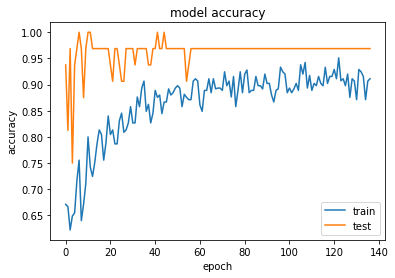

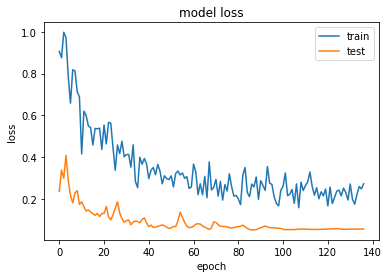

In [0]:
plt.plot(VGG16_history.history['accuracy'])
plt.plot(VGG16_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
 

plt.plot(VGG16_history.history['loss'])
plt.plot(VGG16_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Graph


In [0]:
!pip install -U efficientnet
# https://github.com/qubvel/efficientnet/issues/62

In [0]:
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/hackathon/2020/brain_vgg1000epoch_finetuned.h5")

In [0]:
x_test = []
y_test = []
for t in test_set:
    x_test = t[0]
    y_test = t[1]
    break

              precision    recall  f1-score   support

          NO       1.00      0.80      0.89         5
         YES       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10


Sensitivity	 1.0
Specificity	 0.8


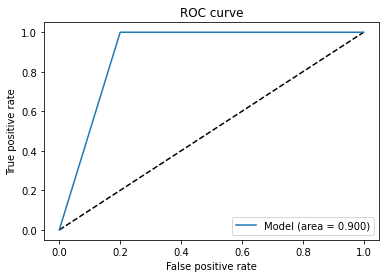

In [0]:
y_pred_keras = loaded_model.predict(x_test)
y_pred_keras_1D = np.round(y_pred_keras).reshape((y_pred_keras.shape[0],))

#  precision    recall  f1-score   support report print
print(metrics.classification_report(np.array(y_test), y_pred_keras_1D, labels=[0,1], target_names=["NO", "YES"]))

# Creating confusion matrix to get true_negatives, false_negatives, true_positives, false_positives
test_confusion_matrix = metrics.confusion_matrix(np.array(y_test), y_pred_keras_1D)

true_negatives = test_confusion_matrix[0][0]
false_negatives = test_confusion_matrix[1][0]
true_positives = test_confusion_matrix[1][1]
false_positives = test_confusion_matrix[0][1]

# Printing sensitivity, specificity
print(f'\nSensitivity\t {np.round(true_positives/(true_positives + false_negatives), 2)}')
print(f'Specificity\t {np.round(true_negatives/(true_negatives + false_positives), 2)}')

# Ploting roc curve and auc
fpr_keras, tpr_keras, _ = metrics.roc_curve(np.array(y_test), y_pred_keras_1D)
auc_keras = metrics.auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()